# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [2]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 14 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 10 days
H2O cluster name:,H2O_from_python_navdeep_b4coc4
H2O cluster total nodes:,1
H2O cluster free memory:,28.19 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


# Helper functions

In [3]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [4]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[2]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

In [5]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

In [6]:
# Load in train and test data used for modelling
train_path = os.sep.join(['..', 'data', 'output', 'train_simulated_processed.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'train_simulated_processed.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# Inputs and output
X = ['binary1',
'binary2',
'cat1_0',
'cat1_1',
'cat1_2',
'cat1_3',
'cat1_4',
'fried1_std',
'fried2_std',
'fried3_std',
'fried4_std',
'fried5_std']
fold_column = 'fold'
Y = "outcome"

In [8]:
# Load in models
mgbm = h2o.load_model('../models/MGBM_BEST_GRID_v2_SIMULATED_1575932311.860524/mgbm_grid2_simulated_model_20') 
gbm = h2o.load_model('../models/GBM_BEST_GRID_v2_SIMULATED_1575932627.142728/gbm_grid2_simulated_model_12')
mxgb = h2o.load_model('../models/MXGB_BEST_GRID_v2_SIMULATED_1575933183.1382315/mxgb_grid2_simulated_model_12')
xgb = h2o.load_model('../models/XGB_BEST_GRID_v2_SIMULATED_1575934130.1232975/xgb_grid2_simulated_model_24')

In [9]:
# Check performance across all models on test set
print(f"Test AUC for Constrained H2O GBM: {mgbm.model_performance(test).auc()}")
print(f"Test AUC for Unconstrained H2O GBM: {gbm.model_performance(test).auc()}\n")
print(f"Test AUC for Constrained H2O XGBoost: {mxgb.model_performance(test).auc()}")
print(f"Test AUC for Unconstrained H2O XGBoost: {xgb.model_performance(test).auc()}\n")

print(f"Test Logloss for Constrained H2O GBM: {mgbm.model_performance(test).logloss()}")
print(f"Test Logloss for Unconstrained H2O GBM: {gbm.model_performance(test).logloss()}\n")
print(f"Test Logloss for Constrained H2O XGBoost: {mxgb.model_performance(test).logloss()}")
print(f"Test Logloss for Unconstrained H2O XGBoost: {xgb.model_performance(test).logloss()}\n")

print(f"Test Accuracy for Constrained H2O GBM: {mgbm.model_performance(test).accuracy()}")
print(f"Test Accuracy for Unconstrained H2O GBM: {gbm.model_performance(test).accuracy()}\n")
print(f"Test Accuracy for Constrained H2O XGBoost: {mxgb.model_performance(test).accuracy()}")
print(f"Test Accuracy for Unconstrained H2O XGBoost: {xgb.model_performance(test).accuracy()}\n")

print(f"Test RMSE for Constrained H2O GBM: {mgbm.model_performance(test).rmse()}")
print(f"Test RMSE for Unconstrained H2O GBM: {gbm.model_performance(test).rmse()}\n")
print(f"Test RMSE for Constrained H2O XGBoost: {mxgb.model_performance(test).rmse()}")
print(f"Test RMSE for Unconstrained H2O XGBoost: {xgb.model_performance(test).rmse()}\n")

Test AUC for Constrained H2O GBM: 0.8455688846364151
Test AUC for Unconstrained H2O GBM: 0.8573019429027835

Test AUC for Constrained H2O XGBoost: 0.850202477467187
Test AUC for Unconstrained H2O XGBoost: 0.8570090820953488

Test Logloss for Constrained H2O GBM: 0.4982379190265672
Test Logloss for Unconstrained H2O GBM: 0.47388774917108056

Test Logloss for Constrained H2O XGBoost: 0.4893971228740355
Test Logloss for Unconstrained H2O XGBoost: 0.4707886987859887

Test Accuracy for Constrained H2O GBM: [[0.4973307702392471, 0.762575]]
Test Accuracy for Unconstrained H2O GBM: [[0.4914791047999211, 0.77485]]

Test Accuracy for Constrained H2O XGBoost: [[0.5171705129649813, 0.7685125]]
Test Accuracy for Unconstrained H2O XGBoost: [[0.4979336851650907, 0.7741]]

Test RMSE for Constrained H2O GBM: 0.4048733809245025
Test RMSE for Unconstrained H2O GBM: 0.39361843935389934

Test RMSE for Constrained H2O XGBoost: 0.40111950729243945
Test RMSE for Unconstrained H2O XGBoost: 0.3929283509843337



# Continue analysis with H2O MGBM and H2O GBM ...

In [10]:
# Get predictions
mgbm_preds = mgbm.predict(test)
print("Constrained H2O GBM Preds")
print(mgbm_preds.head())

gbm_preds = gbm.predict(test)
print("Unconstrained H2O GBM Preds")
print(gbm_preds.head())

gbm prediction progress: |████████████████████████████████████████████████| 100%
Constrained H2O GBM Preds


predict,p0,p1
1,0.416721,0.583279
1,0.0585052,0.941495
1,0.377625,0.622375
0,0.740458,0.259542
0,0.632577,0.367423
1,0.434231,0.565769
0,0.649055,0.350945
0,0.756362,0.243638
0,0.6439,0.3561
1,0.424629,0.575371



gbm prediction progress: |████████████████████████████████████████████████| 100%
Unconstrained H2O GBM Preds


predict,p0,p1
1,0.463445,0.536555
1,0.0506633,0.949337
1,0.385409,0.614591
0,0.756278,0.243722
0,0.652613,0.347387
1,0.457941,0.542059
0,0.814251,0.185749
0,0.858577,0.141423
0,0.688783,0.311217
1,0.294822,0.705178


In [11]:
# Merged predictions from each model onto test set
model_dict = {'mgbm' : mgbm_preds, 'gbm' : gbm_preds}

In [12]:
for model_name, model_preds in model_dict.items():
    yhat = 'outcome_' + model_name + '_pred'
    test = test.cbind(model_preds['p1'])
    test.set_name('p1', yhat)

In [13]:
# Add an ID column to test
test['Id'] = h2o.H2OFrame(np.arange(len(test)))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
test.head()

Unnamed: 0,binary1,binary2,ctrl_class1,ctrl_class2,fold,intercept,latent_no_noise,latent_with_noise,logistic_noise,outcome,outcome_no_noise,prot_class1,prot_class2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,outcome_mgbm_pred,outcome_gbm_pred,Id
51965,1,1,1,1,1,-2.72091,-0.0685853,0.128834,0.19742,1,0,0,0,0,0,0,1,0,1.17751,1.09196,-0.924302,-1.48332,-0.339844,0.583279,0.536555,0
17435,1,1,1,0,2,-2.72091,1.9267,2.82408,0.897373,1,1,0,1,0,0,0,1,0,0.0889578,1.10989,0.0427566,1.59319,0.427192,0.941495,0.949337,1
48424,1,1,1,1,4,-2.72091,0.0715976,0.498041,0.426443,1,1,0,0,0,0,0,1,0,-0.483886,0.886531,0.26511,0.114252,-1.58239,0.622375,0.614591,2
33915,1,1,1,1,1,-2.72091,-0.951668,1.40493,2.3566,1,0,0,0,0,0,0,1,0,-0.937656,0.584315,1.19397,-1.41085,-1.61499,0.259542,0.243722,3
99940,1,0,1,1,2,-2.72091,-0.370235,-0.453614,-0.0833795,0,0,0,0,0,0,1,0,0,0.605907,0.00484684,-0.263273,-1.18119,0.214368,0.367423,0.347387,4
13760,1,1,1,1,4,-2.72091,-0.0891082,1.99819,2.0873,1,0,0,0,0,0,0,1,0,0.32925,-0.0504794,-0.160296,-0.424763,-1.23811,0.565769,0.542059,5
87850,0,1,0,0,1,-2.72091,-0.545174,-1.04493,-0.499752,0,0,1,1,0,0,1,0,0,0.19143,-1.24125,0.488029,1.6645,-0.190901,0.350945,0.185749,6
80162,1,1,1,1,5,-2.72091,-0.983626,-1.69434,-0.710717,0,0,0,0,1,0,0,0,0,-0.993564,0.462289,0.360523,-0.480352,-0.873814,0.243638,0.141423,7
58687,1,1,1,1,5,-2.72091,-0.400844,-0.638193,-0.237349,0,0,0,0,0,0,0,1,0,-0.456458,0.936224,-1.04464,-1.3345,-1.65587,0.3561,0.311217,8
44248,1,1,1,1,3,-2.72091,0.55672,0.562806,0.0060862,1,1,0,0,0,0,1,0,0,0.0178311,0.970295,-0.76748,-0.317553,1.64319,0.575371,0.705178,9


In [15]:
# Export test set with preds
h2o.export_file(test, '../data/output/test_sim_with_preds.csv')

Export File progress: |███████████████████████████████████████████████████| 100%


# Shapley for MGBM on Test Set

In [16]:
shap_values_mgbm, expected_value_mgbm = get_shapley(mgbm, test, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.156505,-0.0527525,0.015272,-0.0372803,0.114948,0.209152,0.00975227,0.566833,0.438278,0.0163506,-1.00812,-0.105594,0.0129074
0.212651,-0.0510355,0.021038,-0.0272618,0.161992,0.410334,0.00840651,0.333398,0.469605,-0.246356,1.22182,0.250856,0.0129074
0.156272,-0.0406393,0.0149368,-0.0259109,0.147559,0.259963,0.00849927,0.06469,0.376811,-0.180763,0.148234,-0.44292,0.0129074
0.113891,-0.037288,0.0246283,-0.0189919,0.120788,0.180305,0.0114431,-0.338792,0.281455,0.0996011,-1.03171,-0.466588,0.0129074
0.157667,0.18137,0.00362476,-0.0577429,-0.417937,-0.194304,0.0052738,0.467043,0.287324,-0.17992,-0.878779,0.0701853,0.0129074


In [17]:
# Write MGBM Shapley frame to disk
mgbm_shapley = pd.DataFrame(shap_values_mgbm, columns=X)
mgbm_shapley['bias'] = expected_value_mgbm
mgbm_shapley.head()
mgbm_shapley.to_csv('../data/output/mgbm_sim_shapley.csv')

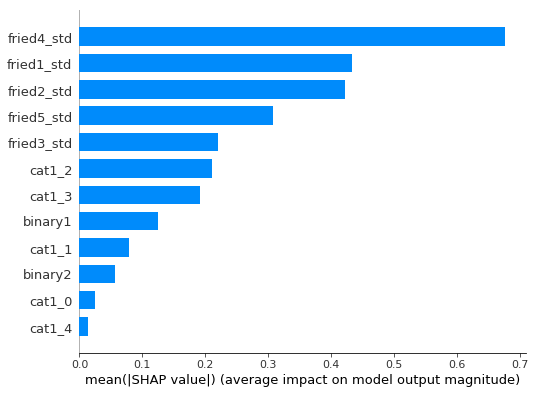

In [18]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

# Shapley for GBM on Test Set

In [19]:
shap_values_gbm, expected_value_gbm = get_shapley(gbm, test, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.133085,-0.0588821,0.0264045,-0.0390189,0.158386,0.194619,0.0266142,0.645756,0.410199,-0.0477406,-1.17478,-0.124538,-0.00362614
0.160709,-0.0325426,0.0292459,-0.0279625,0.220893,0.255453,0.0286658,0.423004,0.618454,-0.277557,1.29376,0.242068,-0.00362614
0.181586,-0.0775272,0.0338387,-0.0499976,0.197505,0.282562,0.0173494,0.0944192,0.482573,-0.336524,0.192706,-0.548212,-0.00362614
0.205384,-0.0796521,0.0282729,-0.0419234,0.170284,0.226346,0.0211825,-0.420502,0.252095,0.225997,-1.19181,-0.524431,-0.00362614
0.135189,0.198471,0.013664,-0.0681182,-0.491704,-0.162228,0.0113478,0.632363,0.287332,-0.31311,-1.02721,0.157091,-0.00362614


In [20]:
# Write MGBM Shapley frame to disk
gbm_shapley = pd.DataFrame(shap_values_gbm, columns=X)
gbm_shapley['bias'] = expected_value_gbm
gbm_shapley.head()
gbm_shapley.to_csv('../data/output/gbm_sim_shapley.csv')

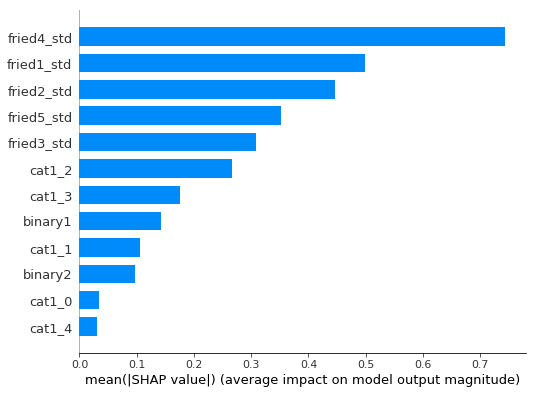

In [21]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

# PDP/ICE for Top 3 Variables from MGBM Global Shapley

## fried4

In [22]:
par_dep_fried4_mgbm = par_dep('fried4_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried4_std  partial_dependence
0    -1.730171            0.247348
1    -1.557055            0.257183
2    -1.383938            0.271972
3    -1.210821            0.287495
4    -1.037704            0.304673
5    -0.864588            0.334027
6    -0.691471            0.366530
7    -0.518354            0.403715
8    -0.345237            0.434871
9    -0.172121            0.453227
10    0.000996            0.487678
11    0.174113            0.544296
12    0.347229            0.576353
13    0.520346            0.605352
14    0.693463            0.627296
15    0.866580            0.673263
16    1.039696            0.684505
17    1.212813            0.716331
18    1.385930            0.734238
19    1.559046            0.747005


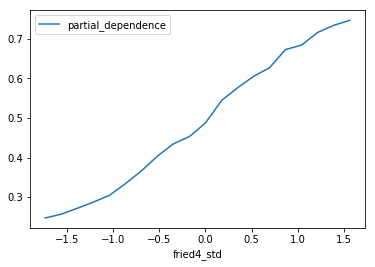

In [23]:
par_dep_fried4_mgbm.plot.line(x='fried4_std', y='partial_dependence')
print(par_dep_fried4_mgbm)

In [24]:
quantile_dict_mgbm = get_quantile_dict('outcome_mgbm_pred', 'Id', test)
bins = list(par_dep_fried4_mgbm['fried4_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried4_mgbm[col_name] = par_dep('fried4_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried4_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried4_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.730171,0.247348,0.006415,0.163319,0.207470,0.185006,0.372285,0.120629,0.168405,0.291569,0.702980,0.192110,0.836303
1,-1.557055,0.257183,0.007346,0.168104,0.216816,0.190321,0.381359,0.139614,0.187215,0.291569,0.702980,0.206506,0.836303
2,-1.383938,0.271972,0.008799,0.178640,0.226168,0.208584,0.392902,0.164702,0.197863,0.295543,0.714962,0.237198,0.848183
3,-1.210821,0.287495,0.009733,0.187165,0.236421,0.212821,0.422238,0.176399,0.213053,0.328031,0.738357,0.263886,0.861689
4,-1.037704,0.304673,0.010493,0.197442,0.242385,0.229502,0.439502,0.186469,0.229482,0.355997,0.766589,0.280216,0.886708
5,-0.864588,0.334027,0.011796,0.224081,0.256929,0.249367,0.482162,0.209761,0.261854,0.387163,0.807467,0.308075,0.918441
6,-0.691471,0.366530,0.015940,0.256554,0.300646,0.286715,0.518917,0.236948,0.300301,0.417983,0.843225,0.343360,0.932497
7,-0.518354,0.403715,0.020837,0.284865,0.336456,0.303358,0.579440,0.277119,0.340839,0.475487,0.866055,0.374772,0.948256
8,-0.345237,0.434871,0.025026,0.306759,0.368118,0.336194,0.611389,0.319057,0.369058,0.508187,0.886278,0.418546,0.957403
9,-0.172121,0.453227,0.028807,0.330386,0.377891,0.358598,0.625895,0.342835,0.400646,0.529101,0.894171,0.441506,0.961897


In [25]:
# Write PDP + ICE frame to disk
par_dep_fried4_mgbm.to_csv('../data/output/mgbm_sim_fried4_pdp_ice.csv')

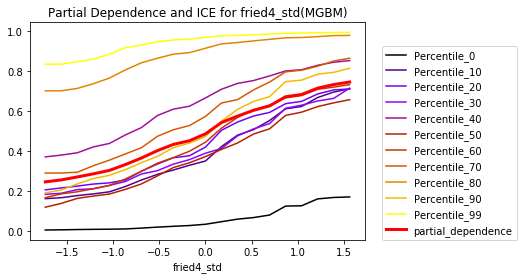

In [26]:
fig, ax = plt.subplots()
par_dep_fried4_mgbm.drop('partial_dependence', axis=1).plot(x='fried4_std', colormap='gnuplot', ax=ax)

par_dep_fried4_mgbm.plot(title='Partial Dependence and ICE for fried4_std(MGBM)',
                         x='fried4_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried1

In [27]:
par_dep_fried1_mgbm = par_dep('fried1_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried1_std  partial_dependence
0    -1.733509            0.247589
1    -1.560082            0.259889
2    -1.386655            0.302895
3    -1.213228            0.329854
4    -1.039801            0.384248
5    -0.866374            0.446468
6    -0.692947            0.472118
7    -0.519520            0.487666
8    -0.346093            0.522852
9    -0.172667            0.547336
10    0.000760            0.571819
11    0.174187            0.579501
12    0.347614            0.594551
13    0.521041            0.605478
14    0.694468            0.610052
15    0.867895            0.612832
16    1.041322            0.619724
17    1.214749            0.621375
18    1.388176            0.625456
19    1.561603            0.627444


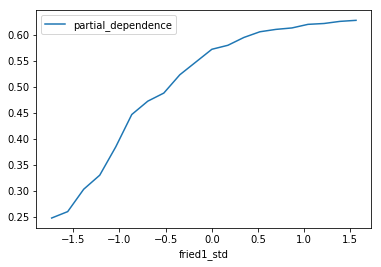

In [28]:
par_dep_fried1_mgbm.plot.line(x='fried1_std', y='partial_dependence')
print(par_dep_fried1_mgbm)

In [29]:
quantile_dict_mgbm = get_quantile_dict('outcome_mgbm_pred', 'Id', test)
bins = list(par_dep_fried1_mgbm['fried1_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried1_mgbm[col_name] = par_dep('fried1_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried1_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried1_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733509,0.247589,0.003192,0.127832,0.056436,0.081835,0.050540,0.116611,0.205706,0.574298,0.219680,0.400090,0.917986
1,-1.560082,0.259889,0.003367,0.140338,0.057242,0.087358,0.056989,0.129415,0.229554,0.594940,0.239440,0.427189,0.917986
2,-1.386655,0.302895,0.005055,0.170100,0.071790,0.115818,0.088871,0.192722,0.291686,0.639971,0.331416,0.523078,0.927791
3,-1.213228,0.329854,0.006576,0.192333,0.085920,0.138062,0.115460,0.222127,0.306702,0.663077,0.384889,0.536920,0.938864
4,-1.039801,0.384248,0.008173,0.233875,0.098626,0.156914,0.182590,0.302049,0.399543,0.726172,0.501382,0.637616,0.954324
5,-0.866374,0.446468,0.013156,0.311181,0.144004,0.209868,0.230594,0.365772,0.466231,0.814331,0.553978,0.716881,0.969524
6,-0.692947,0.472118,0.015512,0.351449,0.162555,0.240194,0.250981,0.412043,0.502845,0.853028,0.580480,0.725975,0.974780
7,-0.519520,0.487666,0.019700,0.385351,0.181539,0.243711,0.296795,0.420361,0.532003,0.860213,0.615972,0.752870,0.975883
8,-0.346093,0.522852,0.027102,0.428921,0.221599,0.260535,0.343753,0.447330,0.580893,0.888803,0.671588,0.768682,0.982373
9,-0.172667,0.547336,0.029652,0.453874,0.244629,0.287735,0.378087,0.473503,0.633379,0.904300,0.693637,0.784914,0.985371


In [30]:
# Write PDP + ICE frame to disk
par_dep_fried1_mgbm.to_csv('../data/output/mgbm_sim_fried1_pdp_ice.csv')

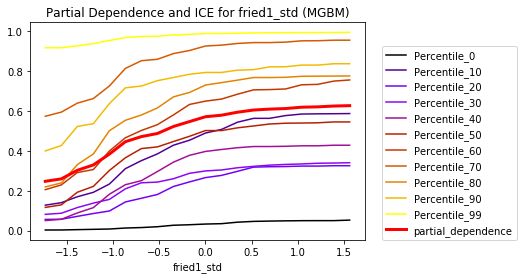

In [31]:
fig, ax = plt.subplots()
par_dep_fried1_mgbm.drop('partial_dependence', axis=1).plot(x='fried1_std', colormap='gnuplot', ax=ax)

par_dep_fried1_mgbm.plot(title='Partial Dependence and ICE for fried1_std (MGBM)',
                         x='fried1_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried2

In [32]:
par_dep_fried2_mgbm = par_dep('fried2_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried2_std  partial_dependence
0    -1.733849            0.244242
1    -1.560644            0.268337
2    -1.387438            0.293652
3    -1.214233            0.338926
4    -1.041027            0.390450
5    -0.867822            0.445994
6    -0.694617            0.466661
7    -0.521411            0.498283
8    -0.348206            0.526648
9    -0.175001            0.551460
10   -0.001795            0.570121
11    0.171410            0.573767
12    0.344616            0.581343
13    0.517821            0.591093
14    0.691026            0.600244
15    0.864232            0.603514
16    1.037437            0.606290
17    1.210642            0.609694
18    1.383848            0.611597
19    1.557053            0.613390


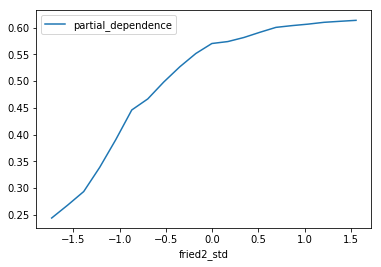

In [33]:
par_dep_fried2_mgbm.plot.line(x='fried2_std', y='partial_dependence')
print(par_dep_fried2_mgbm)

In [34]:
quantile_dict_mgbm = get_quantile_dict('outcome_mgbm_pred', 'Id', test)
bins = list(par_dep_fried2_mgbm['fried2_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried2_mgbm[col_name] = par_dep('fried2_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried2_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried2_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733849,0.244242,0.004565,0.021258,0.044828,0.293237,0.093000,0.244366,0.193775,0.227789,0.203411,0.608239,0.897634
1,-1.560644,0.268337,0.005242,0.024766,0.052495,0.318316,0.118189,0.301736,0.251170,0.280566,0.251346,0.630170,0.908287
2,-1.387438,0.293652,0.007485,0.027227,0.073133,0.350930,0.139922,0.348326,0.284389,0.309273,0.273089,0.701255,0.921748
3,-1.214233,0.338926,0.010185,0.041995,0.085760,0.437367,0.179778,0.401499,0.333761,0.366477,0.339691,0.771510,0.941903
4,-1.041027,0.390450,0.013636,0.052399,0.110661,0.523337,0.243067,0.474388,0.413885,0.422484,0.452832,0.837801,0.966286
5,-0.867822,0.445994,0.018197,0.061920,0.136306,0.590434,0.282490,0.548094,0.486957,0.476641,0.503639,0.881907,0.977100
6,-0.694617,0.466661,0.020904,0.068409,0.150572,0.607016,0.304849,0.581455,0.509072,0.528681,0.532074,0.893268,0.979374
7,-0.521411,0.498283,0.025216,0.081510,0.179412,0.686561,0.339336,0.609436,0.555789,0.571252,0.572245,0.902908,0.981374
8,-0.348206,0.526648,0.032896,0.094673,0.219661,0.726841,0.366208,0.628334,0.580893,0.582593,0.603651,0.923835,0.986395
9,-0.175001,0.551460,0.039308,0.112034,0.251168,0.764637,0.395321,0.656372,0.612434,0.606322,0.644202,0.933538,0.989597


In [35]:
# Write PDP + ICE frame to disk
par_dep_fried2_mgbm.to_csv('../data/output/mgbm_sim_fried2_pdp_ice.csv')

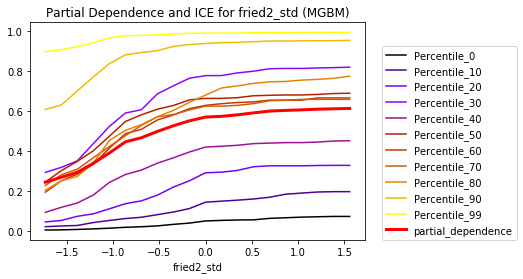

In [36]:
fig, ax = plt.subplots()
par_dep_fried2_mgbm.drop('partial_dependence', axis=1).plot(x='fried2_std', colormap='gnuplot', ax=ax)

par_dep_fried2_mgbm.plot(title='Partial Dependence and ICE for fried2_std (MGBM)',
                         x='fried2_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

# PDP/ICE for Top 3 Variables from GBM Global Shapley

## fried4

In [37]:
par_dep_fried4_gbm = par_dep('fried4_std', test[X], gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried4_std  partial_dependence
0    -1.730171            0.217682
1    -1.557055            0.232124
2    -1.383938            0.253566
3    -1.210821            0.278149
4    -1.037704            0.296316
5    -0.864588            0.326197
6    -0.691471            0.364030
7    -0.518354            0.400281
8    -0.345237            0.424299
9    -0.172121            0.447093
10    0.000996            0.489158
11    0.174113            0.545301
12    0.347229            0.573812
13    0.520346            0.606446
14    0.693463            0.630353
15    0.866580            0.668918
16    1.039696            0.687294
17    1.212813            0.721203
18    1.385930            0.745842
19    1.559046            0.762775


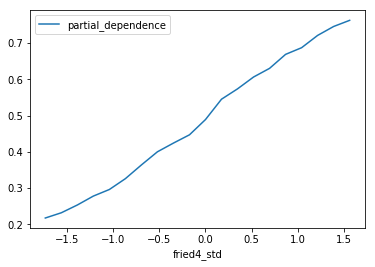

In [38]:
par_dep_fried4_gbm.plot.line(x='fried4_std', y='partial_dependence')
print(par_dep_fried4_gbm)

In [39]:
quantile_dict_gbm = get_quantile_dict('outcome_gbm_pred', 'Id', test)
bins = list(par_dep_fried4_gbm['fried4_std'])
for i in sorted(quantile_dict_gbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried4_gbm[col_name] = par_dep('fried4_std', 
                                            test[test['Id'] == int(quantile_dict_gbm[i])][X], 
                                            gbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried4_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried4_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.730171,0.217682,0.016017,0.029360,0.116236,0.135939,0.171275,0.215553,0.328109,0.215490,0.560330,0.379800,0.796261
1,-1.557055,0.232124,0.016307,0.029926,0.158829,0.139924,0.184700,0.242723,0.342789,0.214345,0.582578,0.422915,0.853795
2,-1.383938,0.253566,0.017400,0.032738,0.178397,0.160359,0.206170,0.269353,0.385583,0.225736,0.621432,0.460972,0.900165
3,-1.210821,0.278149,0.018281,0.036214,0.178995,0.166400,0.211233,0.283721,0.421496,0.245118,0.674635,0.486941,0.906021
4,-1.037704,0.296316,0.019428,0.040612,0.184707,0.186902,0.236012,0.289936,0.443895,0.285457,0.704843,0.542723,0.919015
5,-0.864588,0.326197,0.018673,0.045410,0.190292,0.249291,0.270105,0.322900,0.486111,0.331568,0.766214,0.572458,0.939274
6,-0.691471,0.364030,0.020482,0.056665,0.198637,0.268204,0.305979,0.367817,0.553280,0.371654,0.789669,0.629183,0.935746
7,-0.518354,0.400281,0.022218,0.064825,0.240433,0.293082,0.332066,0.477895,0.639024,0.422598,0.835295,0.695165,0.947359
8,-0.345237,0.424299,0.026396,0.074050,0.284412,0.335938,0.361066,0.499407,0.645959,0.442703,0.849484,0.724608,0.951357
9,-0.172121,0.447093,0.026732,0.076732,0.320240,0.388492,0.396989,0.513545,0.673905,0.508056,0.862504,0.737583,0.951703


In [40]:
# Write PDP + ICE frame to disk
par_dep_fried4_gbm.to_csv('../data/output/gbm_sim_fried4_pdp_ice.csv')

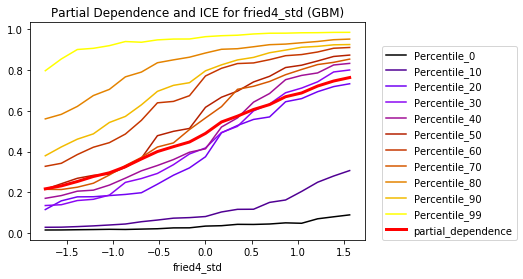

In [41]:
fig, ax = plt.subplots()
par_dep_fried4_gbm.drop('partial_dependence', axis=1).plot(x='fried4_std', colormap='gnuplot', ax=ax)

par_dep_fried4_gbm.plot(title='Partial Dependence and ICE for fried4_std (GBM)',
                         x='fried4_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried1

In [47]:
par_dep_fried1_gbm = par_dep('fried1_std', test[X], gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried1_std  partial_dependence
0    -1.733509            0.205971
1    -1.560082            0.225188
2    -1.386655            0.282490
3    -1.213228            0.324466
4    -1.039801            0.375011
5    -0.866374            0.434902
6    -0.692947            0.464639
7    -0.519520            0.484813
8    -0.346093            0.519287
9    -0.172667            0.544551
10    0.000760            0.570411
11    0.174187            0.580918
12    0.347614            0.594503
13    0.521041            0.613876
14    0.694468            0.620862
15    0.867895            0.630168
16    1.041322            0.634171
17    1.214749            0.636265
18    1.388176            0.639932
19    1.561603            0.641850


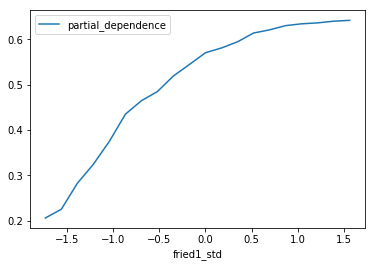

In [48]:
par_dep_fried1_gbm.plot.line(x='fried1_std', y='partial_dependence')
print(par_dep_fried1_gbm)

In [49]:
quantile_dict_gbm = get_quantile_dict('outcome_gbm_pred', 'Id', test)
bins = list(par_dep_fried1_gbm['fried1_std'])
for i in sorted(quantile_dict_gbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried1_gbm[col_name] = par_dep('fried1_std', 
                                            test[test['Id'] == int(quantile_dict_gbm[i])][X], 
                                            gbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried1_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried1_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733509,0.205971,0.012432,0.090002,0.026901,0.083909,0.057278,0.076204,0.085767,0.335246,0.216426,0.555500,0.825678
1,-1.560082,0.225188,0.012275,0.093975,0.027713,0.086286,0.058892,0.080181,0.096798,0.418987,0.259591,0.585484,0.849355
2,-1.386655,0.282490,0.015263,0.105774,0.036299,0.122655,0.090718,0.122104,0.127487,0.527721,0.378842,0.645226,0.908946
3,-1.213228,0.324466,0.016151,0.116368,0.038986,0.141955,0.120896,0.126918,0.138446,0.609787,0.533085,0.676125,0.925412
4,-1.039801,0.375011,0.018624,0.146417,0.046487,0.183526,0.149499,0.160260,0.185288,0.715272,0.638344,0.714462,0.954352
5,-0.866374,0.434902,0.020191,0.207402,0.054622,0.202130,0.207897,0.219795,0.270175,0.784400,0.754809,0.779106,0.968838
6,-0.692947,0.464639,0.021186,0.253103,0.057094,0.245408,0.223561,0.254407,0.330583,0.820649,0.786088,0.784683,0.971263
7,-0.519520,0.484813,0.022320,0.277970,0.062460,0.249895,0.231747,0.269221,0.361160,0.835432,0.805740,0.804534,0.974522
8,-0.346093,0.519287,0.025177,0.330007,0.083752,0.249418,0.247680,0.305200,0.399167,0.859571,0.814655,0.813115,0.977455
9,-0.172667,0.544551,0.027240,0.389662,0.103190,0.254935,0.270358,0.431476,0.441245,0.880639,0.826324,0.827423,0.979253


In [50]:
# Write PDP + ICE frame to disk
par_dep_fried1_gbm.to_csv('../data/output/gbm_sim_fried1_pdp_ice.csv')

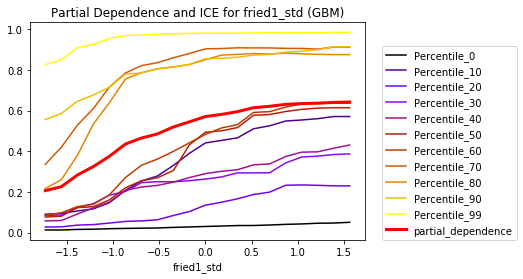

In [51]:
fig, ax = plt.subplots()
par_dep_fried1_gbm.drop('partial_dependence', axis=1).plot(x='fried1_std', colormap='gnuplot', ax=ax)

par_dep_fried1_gbm.plot(title='Partial Dependence and ICE for fried1_std (GBM)',
                         x='fried1_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried2

In [42]:
par_dep_fried2_gbm = par_dep('fried2_std', test[X], gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried2_std  partial_dependence
0    -1.733849            0.225894
1    -1.560644            0.249476
2    -1.387438            0.278181
3    -1.214233            0.327238
4    -1.041027            0.374504
5    -0.867822            0.434443
6    -0.694617            0.456877
7    -0.521411            0.488529
8    -0.348206            0.517580
9    -0.175001            0.543080
10   -0.001795            0.562931
11    0.171410            0.575790
12    0.344616            0.588591
13    0.517821            0.600803
14    0.691026            0.616214
15    0.864232            0.621882
16    1.037437            0.626297
17    1.210642            0.632208
18    1.383848            0.630966
19    1.557053            0.629815


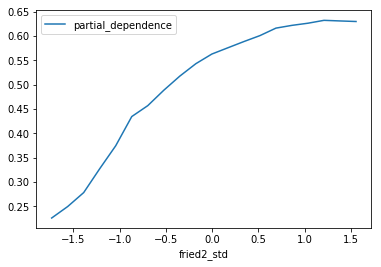

In [43]:
par_dep_fried2_gbm.plot.line(x='fried2_std', y='partial_dependence')
print(par_dep_fried2_gbm)

In [44]:
quantile_dict_gbm = get_quantile_dict('outcome_gbm_pred', 'Id', test)
bins = list(par_dep_fried2_gbm['fried2_std'])
for i in sorted(quantile_dict_gbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried2_gbm[col_name] = par_dep('fried2_std', 
                                            test[test['Id'] == int(quantile_dict_gbm[i])][X], 
                                            gbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried2_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried2_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733849,0.225894,0.014791,0.044656,0.035249,0.152412,0.229295,0.103745,0.157511,0.289501,0.256929,0.444569,0.888981
1,-1.560644,0.249476,0.014462,0.046174,0.040594,0.160002,0.250183,0.105159,0.174377,0.296987,0.306821,0.497768,0.913508
2,-1.387438,0.278181,0.017250,0.053783,0.051716,0.221300,0.305818,0.119407,0.210420,0.295252,0.296035,0.589119,0.925770
3,-1.214233,0.327238,0.018896,0.077155,0.062057,0.293082,0.406714,0.148712,0.301062,0.364259,0.357776,0.671731,0.932024
4,-1.041027,0.374504,0.019689,0.091701,0.066473,0.390313,0.490177,0.166675,0.356861,0.446898,0.357654,0.764866,0.953013
5,-0.867822,0.434443,0.021385,0.099887,0.095557,0.472768,0.689757,0.225146,0.420793,0.490370,0.495366,0.825306,0.963396
6,-0.694617,0.456877,0.023037,0.100349,0.110443,0.549198,0.718143,0.299060,0.498130,0.491681,0.520864,0.831868,0.966685
7,-0.521411,0.488529,0.024464,0.106415,0.133102,0.627067,0.790784,0.364288,0.580739,0.521011,0.553914,0.862123,0.969271
8,-0.348206,0.517580,0.027741,0.116917,0.149052,0.705929,0.842177,0.393764,0.614540,0.563084,0.580772,0.879845,0.973548
9,-0.175001,0.543080,0.028386,0.126380,0.184586,0.738897,0.856692,0.457434,0.668829,0.595013,0.603485,0.896603,0.977626


In [45]:
# Write PDP + ICE frame to disk
par_dep_fried2_gbm.to_csv('../data/output/gbm_sim_fried2_pdp_ice.csv')

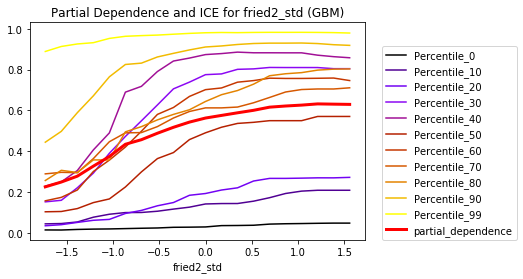

In [46]:
fig, ax = plt.subplots()
par_dep_fried2_gbm.drop('partial_dependence', axis=1).plot(x='fried2_std', colormap='gnuplot', ax=ax)

par_dep_fried2_gbm.plot(title='Partial Dependence and ICE for fried2_std (GBM)',
                         x='fried2_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)